In [28]:
################################################################################
# Discription             : Predict script 
# Author                  : Saiful islam
# Copyright               : Semanticslab.net
# SPDX-License-Identifier : Apache-2.0
################################################################################

# !pip install mxboard
# !pip install matplotlib
# !pip install tqdm
# !pip install opencv-python
# !pip install pandas
import json
import multiprocessing
import os
import random
import string
import time
import matplotlib.pyplot as plt
from mxboard import SummaryWriter
import mxnet as mx
from mxnet import nd, autograd, gluon
# from mxnet.gluon.model_zoo.vision import resnet34_v1
from mxnet.gluon.model_zoo.vision import resnet50_v1
import numpy as np
from skimage import transform as skimage_tf
from skimage import exposure
from tqdm import tqdm
np.seterr(all='raise')

mx.random.seed(1)

SORBORNO_BORNO = ["অ","আ","ই","ঈ","উ","ঊ","ঋ","এ","ঐ","ও","ঔ"]
BENJON_BORNO = ["ক","খ","গ","ঘ","ঙ","চ","ছ","জ","ঝ","ঞ","ট","ঠ","ড","ঢ","ণ","ত","থ","দ","ধ","ন","প","ফ","ব","ভ","ম","য","র","ল","শ","ষ","স","হ","ড়","ঢ়","য়"]
COMBINATION_001 = ["ক্ক","ক্কা","ক্কি","ক্কী","ক্কু","ক্কূ","ক্কে","ক্কো"]
COMBINATION_011 = ["ক্ষ","ক্ষা","ক্ষি","ক্ষী","ক্ষু","ক্ষূ","ক্ষে","ক্ষো"]
COMBINATION_010 = ["ক্ল"]
#TODO 15-01-2020
MO_COMBINATION = ["মা","মি","মী","মু","মূ","মৃ","মে","মৈ","মো","মৌ"]
PO_COMBINATION = ["পা","পি","পী","পু","পূ","পৃ","পে","পৈ","পো","পৌ"]
NNO_COMBINATION = ["না","নি","নী","নু","নূ","নৃ","নে","নৈ","নো","নৌ"]
LO_COMBINATION = ["লা","লি","লী","লু","লূ","লৃ","লে","লৈ","লো","লৌ"]
DDHO_COMBINATION = ["ধা","ধি","ধী","ধু","ধূ","ধৃ","ধে","ধৈ","ধো","ধৌ"]
COMBINATION_002 = ["ক্ট","ক্টা","ক্টি","ক্টী","ক্টু","ক্টূ","ক্টে","ক্টো"]
COMBINATION_RANDOM =["ক্ট্র","ক্ট্রা","ক্ট্রি","ক্ট্রী","ক্ট্রে","ক্ট্রো"]
COMBINATION_004 = ["ক্ত","ক্তা","ক্তি","ক্তী","ক্তু","ক্তূ","ক্তে","ক্তো"]
COMBINATION_058 = ["ঞ্চ","ঞ্চা","ঞ্চি","ঞ্চী","ঞ্চু","ঞ্চূ","ঞ্চে","ঞ্চো"]

NER_CHARACTER = MO_COMBINATION+PO_COMBINATION+NNO_COMBINATION+LO_COMBINATION+DDHO_COMBINATION+COMBINATION_002+COMBINATION_RANDOM+COMBINATION_004+COMBINATION_058

# print(NER_CHARACTER)
#end todo

SPACE_CHAR=" "
BANJON_BORNO_SPATIAL   = 'ং ঃ ৎ'.replace(SPACE_CHAR, '')
BANJON_BORNO_SPATIAL= [i for i in BANJON_BORNO_SPATIAL]

ENDING_SYMBOLS         = 'া ে ো  ৈ ি ী ৗ'.replace(SPACE_CHAR, '')
ENDING_SYMBOLS = [i for i in ENDING_SYMBOLS]

ENDING_SYMBOLS_SPATIAL = 'ু ূ ৃ ্'.replace(SPACE_CHAR, '')
ENDING_SYMBOLS_SPATIAL = [i for i in ENDING_SYMBOLS_SPATIAL]
CHONDRO_BRINDO         = ['ঁ']

ALL_COMBINE =[" "]+SORBORNO_BORNO+BENJON_BORNO+COMBINATION_001+COMBINATION_011+COMBINATION_010+BANJON_BORNO_SPATIAL+ENDING_SYMBOLS+ENDING_SYMBOLS_SPATIAL+CHONDRO_BRINDO+NER_CHARACTER
print(len(ALL_COMBINE))
alphabet_dict = {ALL_COMBINE[i]:i for i in range(len(ALL_COMBINE))}
print(len(alphabet_dict))
alphabet_encoding_dic = {i:ALL_COMBINE[i] for i in range(len(ALL_COMBINE))}
print(len(alphabet_encoding_dic))
print(alphabet_encoding_dic)


159
159
159
{0: ' ', 1: 'অ', 2: 'আ', 3: 'ই', 4: 'ঈ', 5: 'উ', 6: 'ঊ', 7: 'ঋ', 8: 'এ', 9: 'ঐ', 10: 'ও', 11: 'ঔ', 12: 'ক', 13: 'খ', 14: 'গ', 15: 'ঘ', 16: 'ঙ', 17: 'চ', 18: 'ছ', 19: 'জ', 20: 'ঝ', 21: 'ঞ', 22: 'ট', 23: 'ঠ', 24: 'ড', 25: 'ঢ', 26: 'ণ', 27: 'ত', 28: 'থ', 29: 'দ', 30: 'ধ', 31: 'ন', 32: 'প', 33: 'ফ', 34: 'ব', 35: 'ভ', 36: 'ম', 37: 'য', 38: 'র', 39: 'ল', 40: 'শ', 41: 'ষ', 42: 'স', 43: 'হ', 44: 'ড়', 45: 'ঢ়', 46: 'য়', 47: 'ক্ক', 48: 'ক্কা', 49: 'ক্কি', 50: 'ক্কী', 51: 'ক্কু', 52: 'ক্কূ', 53: 'ক্কে', 54: 'ক্কো', 55: 'ক্ষ', 56: 'ক্ষা', 57: 'ক্ষি', 58: 'ক্ষী', 59: 'ক্ষু', 60: 'ক্ষূ', 61: 'ক্ষে', 62: 'ক্ষো', 63: 'ক্ল', 64: 'ং', 65: 'ঃ', 66: 'ৎ', 67: 'া', 68: 'ে', 69: 'ো', 70: 'ৈ', 71: 'ি', 72: 'ী', 73: 'ৗ', 74: 'ু', 75: 'ূ', 76: 'ৃ', 77: '্', 78: 'ঁ', 79: 'মা', 80: 'মি', 81: 'মী', 82: 'মু', 83: 'মূ', 84: 'মৃ', 85: 'মে', 86: 'মৈ', 87: 'মো', 88: 'মৌ', 89: 'পা', 90: 'পি', 91: 'পী', 92: 'পু', 93: 'পূ', 94: 'পৃ', 95: 'পে', 96: 'পৈ', 97: 'পো', 98: 'পৌ', 99: 'না', 100: 'নি', 101: 'নী', 102: '

In [29]:
class EncoderLayer(gluon.HybridBlock):
    '''
    The encoder layer takes the image features from a CNN. The image features are transposed so that the LSTM 
    slices of the image features can be sequentially fed into the LSTM from left to right (and back via the
    bidirectional LSTM). 
    '''
    def __init__(self, hidden_states=200, rnn_layers=1, max_seq_len=100, **kwargs):
        self.max_seq_len = max_seq_len
        super(EncoderLayer, self).__init__(**kwargs)
        with self.name_scope():
            self.lstm = mx.gluon.rnn.LSTM(hidden_states, rnn_layers, bidirectional=True)
            
    def hybrid_forward(self, F, x):
        x = x.transpose((0, 3, 1, 2))
        x = x.flatten()
        x = x.split(num_outputs=self.max_seq_len, axis=1) # (SEQ_LEN, N, CHANNELS)
        x = F.concat(*[elem.expand_dims(axis=0) for elem in x], dim=0)
        x = self.lstm(x)
        x = x.transpose((1, 0, 2)) #(N, SEQ_LEN, HIDDEN_UNITS)
        return x

class CNNBiLSTM(gluon.HybridBlock):
    '''
    The CNN-biLSTM to recognise handwriting text given an image of handwriten text.
    Parameters
    ----------
    num_downsamples: int, default 2
        The number of times to downsample the image features. Each time the features are downsampled, a new LSTM
        is created. 
    resnet_layer_id: int, default 4
        The layer ID to obtain features from the resnet34
    lstm_hidden_states: int, default 200
        The number of hidden states used in the LSTMs
    lstm_layers: int, default 1
        The number of layers of LSTMs to use
    '''
    FEATURE_EXTRACTOR_FILTER = 64
    def __init__(self, num_downsamples=2, resnet_layer_id=4, rnn_hidden_states=200, rnn_layers=1, max_seq_len=100, ctx=mx.gpu(0), **kwargs):
        super(CNNBiLSTM, self).__init__(**kwargs)
        self.p_dropout = 0.5
        self.num_downsamples = num_downsamples
        self.max_seq_len = max_seq_len
        self.ctx = ctx
        with self.name_scope():
            self.body = self.get_body(resnet_layer_id=resnet_layer_id)

            self.encoders = gluon.nn.HybridSequential()
            with self.encoders.name_scope():
                for i in range(self.num_downsamples):
                    encoder = self.get_encoder(rnn_hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len)
                    self.encoders.add(encoder)
            self.decoder = self.get_decoder()
            self.downsampler = self.get_down_sampler(self.FEATURE_EXTRACTOR_FILTER)

    def get_down_sampler(self, num_filters):
        '''
        Creates a two-stacked Conv-BatchNorm-Relu and then a pooling layer to
        downsample the image features by half.
        
        Parameters
        ----------
        num_filters: int
            To select the number of filters in used the downsampling convolutional layer.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The downsampler network that decreases the width and height of the image features by half.
        
        '''
        out = gluon.nn.HybridSequential()
        with out.name_scope():
            for _ in range(2):
                out.add(gluon.nn.Conv2D(num_filters, 3, strides=1, padding=1))
                out.add(gluon.nn.BatchNorm(in_channels=num_filters))
                out.add(gluon.nn.Activation('relu'))
            out.add(gluon.nn.MaxPool2D(2))
            out.collect_params().initialize(mx.init.Normal(), ctx=self.ctx)
        out.hybridize()
        return out

    def get_body(self, resnet_layer_id):
        '''
        Create the feature extraction network based on resnet34.
        The first layer of the res-net is converted into grayscale by averaging the weights of the 3 channels
        of the original resnet.
        
        Parameters
        ----------
        resnet_layer_id: int
            The resnet_layer_id specifies which layer to take from 
            the bottom of the network.
        Returns
        -------
        network: gluon.nn.HybridSequential
            The body network for feature extraction based on resnet
        '''
        
        pretrained = resnet50_v1(pretrained=True, ctx=self.ctx)
        pretrained_2 = resnet50_v1(pretrained=True, ctx=mx.cpu(0))
        first_weights = pretrained_2.features[0].weight.data().mean(axis=1).expand_dims(axis=1)
        # First weights could be replaced with individual channels.
        
        body = gluon.nn.HybridSequential()
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Xavier(), ctx=self.ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:-resnet_layer_id])
        return body

    def get_encoder(self, rnn_hidden_states, rnn_layers, max_seq_len):
        '''
        Creates an LSTM to learn the sequential component of the image features.
        
        Parameters
        ----------
        
        rnn_hidden_states: int
            The number of hidden states in the RNN
        
        rnn_layers: int
            The number of layers to stack the RNN
        Returns
        -------
        
        network: gluon.nn.Sequential
            The encoder network to learn the sequential information of the image features
        '''

        encoder = gluon.nn.HybridSequential()
        with encoder.name_scope():
            encoder.add(EncoderLayer(hidden_states=rnn_hidden_states, rnn_layers=rnn_layers, max_seq_len=max_seq_len))
            encoder.add(gluon.nn.Dropout(self.p_dropout))
        encoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return encoder
    
    def get_decoder(self):
        '''
        Creates a network to convert the output of the encoder into characters.
        '''

        alphabet_size = len(alphabet_encoding_dic) + 1
        decoder = mx.gluon.nn.Dense(units=alphabet_size, flatten=False)
        decoder.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        return decoder

    def hybrid_forward(self, F, x):
        features = self.body(x)
        hidden_states = []
        hs = self.encoders[0](features)
        hidden_states.append(hs)
        for i, _ in enumerate(range(self.num_downsamples - 1)):
            features = self.downsampler(features)
            hs = self.encoders[i+1](features)
            hidden_states.append(hs)
        hs = F.concat(*hidden_states, dim=2)
        output = self.decoder(hs)
        return output

In [30]:
ctc_loss = gluon.loss.CTCLoss(weight=0.2)
best_test_loss = 10e5

In [31]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

epochs = 100
learning_rate = 0.0001
batch_size = 64

# max_seq_len = 160
max_seq_len = 32
print_every_n = 5
send_image_every_n = 5

num_downsamples = 2
resnet_layer_id = 4
# lstm_hidden_states = 200
lstm_hidden_states = 512
lstm_layers = 2

random_y_translation, random_x_translation = 0.03, 0.03
random_y_scaling, random_x_scaling = 0.1, 0.1
random_shearing = 0.7

log_dir = "./logs/handwriting_recognition"
checkpoint_dir = "model_checkpoint"
checkpoint_name = "handwriting.params"

In [32]:
print("Network Initialization...................")
net = CNNBiLSTM(num_downsamples=num_downsamples, resnet_layer_id=resnet_layer_id , rnn_hidden_states=lstm_hidden_states, rnn_layers=lstm_layers, max_seq_len=max_seq_len, ctx=ctx)
net.hybridize()

Network Initialization...................


In [33]:
if (os.path.isfile(os.path.join(checkpoint_dir, checkpoint_name))):
    net.load_parameters(os.path.join(checkpoint_dir, checkpoint_name))
    print("Parameters loaded")
#     print(run_epoch(0, net, test_data, None, log_dir, print_name="pretrained", is_train=False))
else:
    print("Please make sure your pretrain directory")
    

Parameters loaded


In [43]:
def decode(prediction):
    '''
    Returns the string given one-hot encoded vectors.
    '''
    results = []
    for word in prediction:
        result = []
        for i, index in enumerate(word):
#             print(i,index)
            if i < len(word) - 1 and word[i] == word[i+1] and word[-1] != -1: #Hack to decode label as well
                continue
            if index == len(alphabet_dict) or index == -1:
                continue
            else:
                result.append(alphabet_encoding_dic[int(index)])
#                 result.append(alphabet_encoding[int(index)])
                
        print(result)
        
        results.append(result)
    words = [''.join(word) for word in results]
    return words

In [44]:

def transform(image):
    '''
    This function resizes the input image and converts so that it could be fed into the network.
    Furthermore, the label (text) is one-hot encoded.
    '''
    image = np.expand_dims(image, axis=0).astype(np.float32)
    if image[0, 0, 0] > 1:
        image = image/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    return image

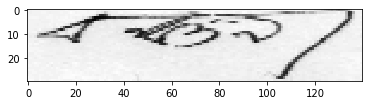

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


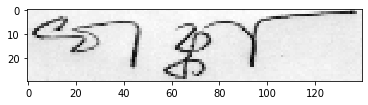

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


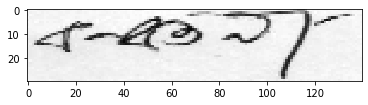

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


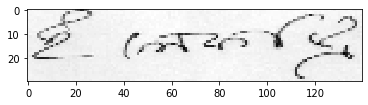

['ই', 'ল', 'ে', 'ক', '্', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেক্ট্রিক


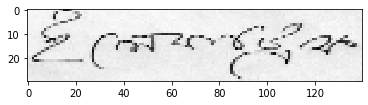

['ই', 'ল', 'ে', 'ক', '্', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেক্ট্রিক


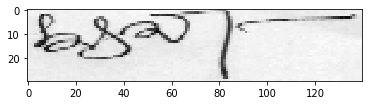

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


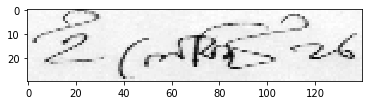

['ই', 'ল', 'ে', 'ক', '্', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেক্ট্রিক


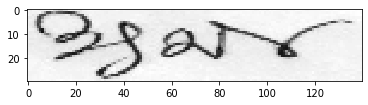

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


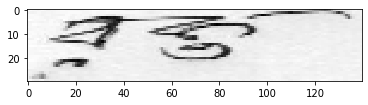

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


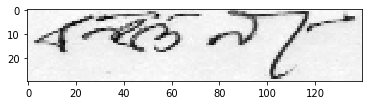

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


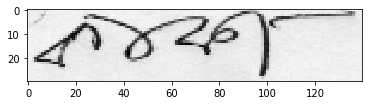

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


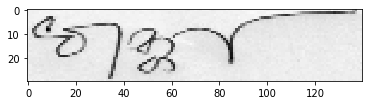

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


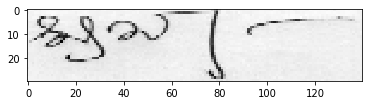

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


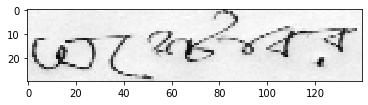

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


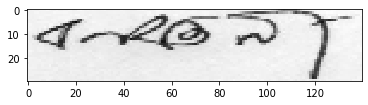

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


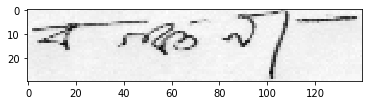

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


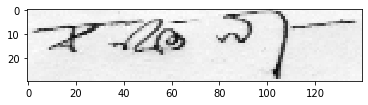

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


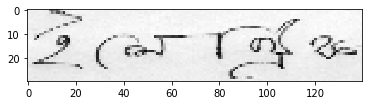

['ই', 'ল', 'ে', 'ক', '্', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেক্ট্রিক


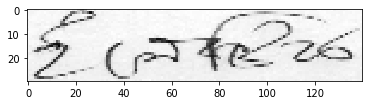

['ই', 'ল', 'ে', 'ক', '্', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেক্ট্রিক


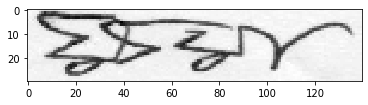

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


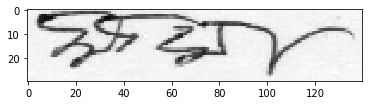

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


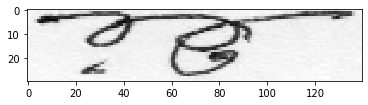

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


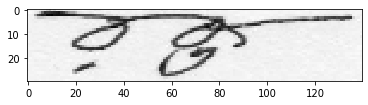

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


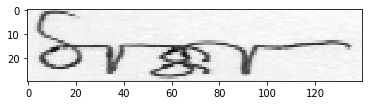

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


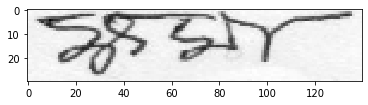

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


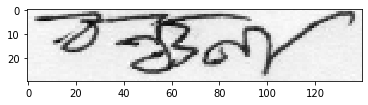

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


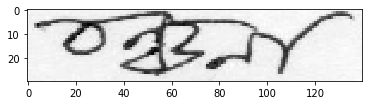

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


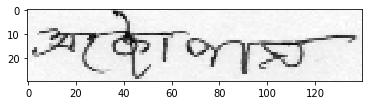

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


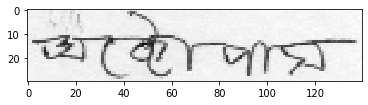

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


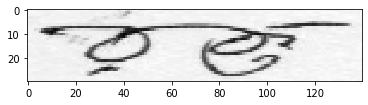

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


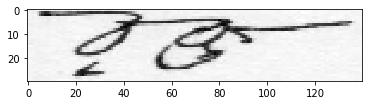

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


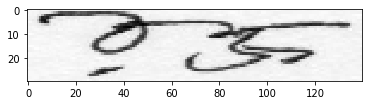

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


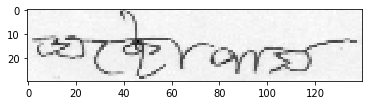

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


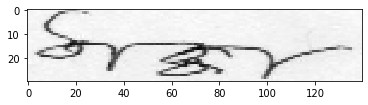

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


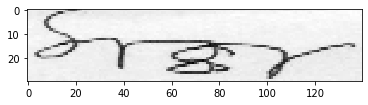

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


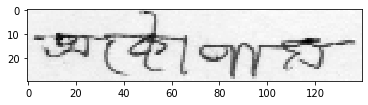

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


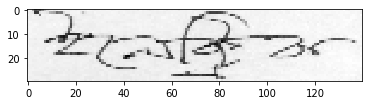

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


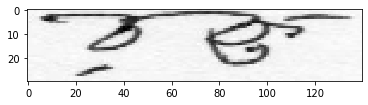

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


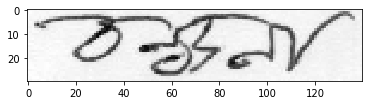

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


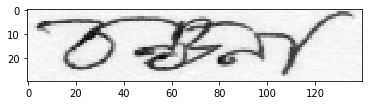

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


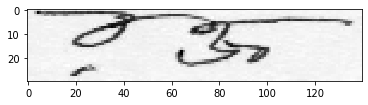

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


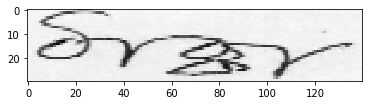

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


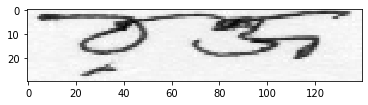

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


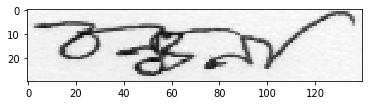

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


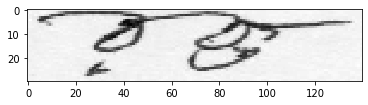

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


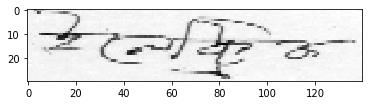

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


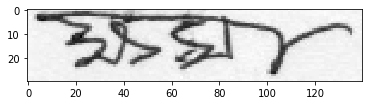

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


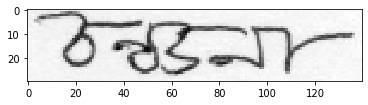

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


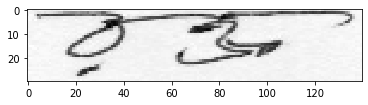

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


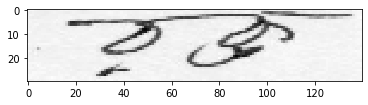

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


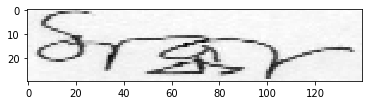

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


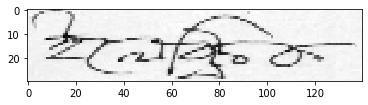

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


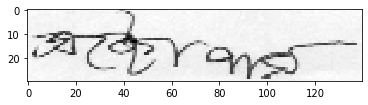

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


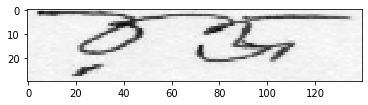

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


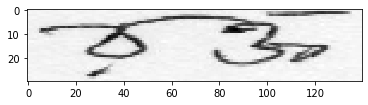

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


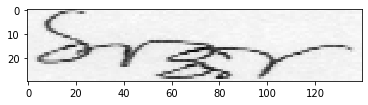

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


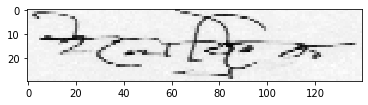

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


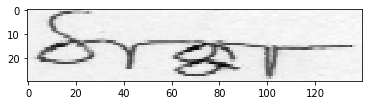

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


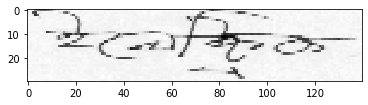

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


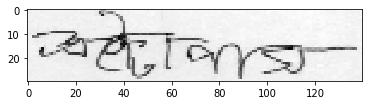

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


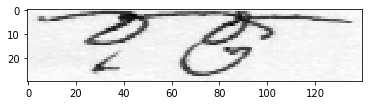

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


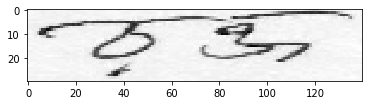

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


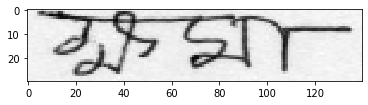

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


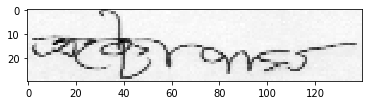

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


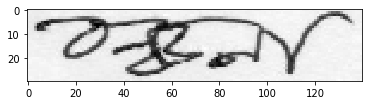

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


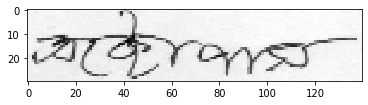

['অ', 'ক', '্', 'ট', 'ো', 'প', 'া', 'স']
Decoded Prediction: অক্টোপাস


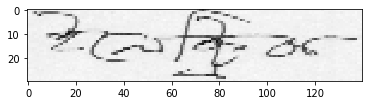

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


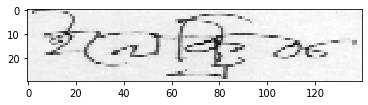

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


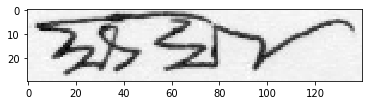

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


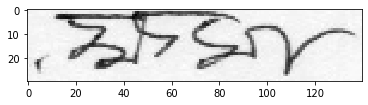

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


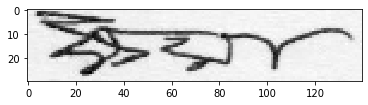

['ক', '্', 'ষ', 'ম', 'া']
Decoded Prediction: ক্ষমা


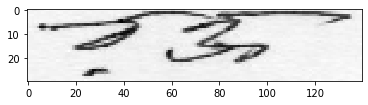

['র', 'ক', '্', 'ত']
Decoded Prediction: রক্ত


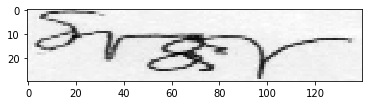

['ধ', 'া', 'ক', '্', 'ক', 'া']
Decoded Prediction: ধাক্কা


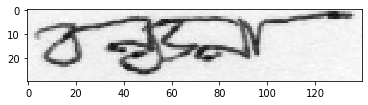

['ব', 'ঞ', '্', 'চ', 'ন', 'া']
Decoded Prediction: বঞ্চনা


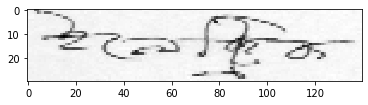

['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
Decoded Prediction: ইলেকট্রিক


In [45]:
# total_number_of_word=[]
# miss_predict_number_of_word=[]
# currect_predict_word = []

desired_size = (60, 800)

def get_image_resize(image):
    size = image.shape[:2]
    if size[0] > desired_size[0] or size[1] > desired_size[1]:
        ratio_w = float(desired_size[0])/size[0]
        ratio_h = float(desired_size[1])/size[1]
        ratio = min(ratio_w, ratio_h)
        new_size = tuple([int(x*ratio) for x in size])
        image = cv2.resize(image, (new_size[1], new_size[0]))
        size = image.shape
            
    delta_w = max(0, desired_size[1] - size[1])
    delta_h = max(0, desired_size[0] - size[0])
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
            
    color = 255
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=float(color))
    image[image > 240] = 255
    return image


img_path = glob.glob("test/*/*jpg")
cnt=0

for i in img_path:
    img = cv2.imread(i,0)
    image = get_image_resize(img)
    
#     image = cv2.resize(img, (140,30))
    plt.imshow(image,cmap="gray")
    plt.show()
    
    image= transform(image)
    
    image = nd.array(image)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    output = net(image)
    predictions = output.softmax().topk(axis=2).asnumpy()
    decoded_prediction_text = decode(predictions)[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')
    print("Decoded Prediction:",decoded_prediction_text)
    

    
# plt.figure(figsize=(12, 24))
# for index, row in sample_test.iterrows():
#     filename = row['filename']
#     category = row['category']
#     img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
#     plt.subplot(6, 3, index+1)
#     plt.imshow(img)
#     plt.xlabel(filename + '(' + "{}".format(category) + ')' )
# plt.tight_layout()
# plt.show()
#     cnt+=1
    
# print("Number of data :",cnt)
    
#     label =str(actual_label[0])
#     prediction = decoded_prediction_text
#     print(label,prediction)
#     edit_distance = editdistance.eval(label, prediction)
#     if edit_distance > 0:
#         miss_predict_number_of_word.append(prediction)
#     else:
#         currect_predict_word.append(prediction)
    
#     total_number_of_word.append(prediction)
    
# print("Total Word :",len(total_number_of_word))
# print("Miss Predict word :",len(miss_predict_number_of_word))
# print("Currect Predcit Word :",len(currect_predict_word))

# word_accuracy_rate = (len(currect_predict_word)*100)/len(total_number_of_word)
# print("Accuracy :",word_accuracy_rate,"%")
# print("Word Error Rate :",100-word_accuracy_rate,"%")

In [46]:
l=['ই', 'ল', 'ে', 'ক', 'ট', '্', 'র', 'ি', 'ক']
x = "".join(i for i in l)
x

'ইলেকট্রিক'